In [4]:
# libraries
import swifter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter

# text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# topic modeling
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary

# initialize global variables
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# time series
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa import ar_model
from sklearn.metrics import mean_squared_error
from scipy.stats.distributions import chi2
import warnings
import pmdarima as pm

# download nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

/opt/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/vramos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vramos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vramos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vramos/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Dynamic Topic Modeling 

#### Weekly

In [37]:
# read csv
comments = pd.read_csv('../data/processed/comments.csv')
# sort by date
comments = comments.sort_values(by='datetime')
# drop rows with missing values
comments = comments.dropna()
comments = comments.reset_index(drop=True)
comments['date_day'] = pd.to_datetime(comments['date_day'])

comments


,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
0,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
1,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
2,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
3,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
4,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01
...,...,...,...,...,...,...,...,...,...
167794,politics,t3_1gjdfxd,t1_lvfrzmk,t1_lvfrjhp,2024-11-05 00:58:37,7,7,"Trump up 4 points in Maryland!\n\n(""See? That ...",2024-11-05
167795,politics,t3_1gjdfxd,t1_lvfs1gu,t3_1gjdfxd,2024-11-05 00:58:54,12,12,"At this point the only states im ""worried"" abo...",2024-11-05
167796,politics,t3_1gjdfxd,t1_lvfs1k6,t1_lvfre42,2024-11-05 00:58:55,-5,-5,He's been saying the same script for the past ...,2024-11-05
167797,Conservative,t3_1gjrpbw,t1_lvfs3rk,t1_lvfqjvl,2024-11-05 00:59:17,49,49,This is the same county that the court case fo...,2024-11-05


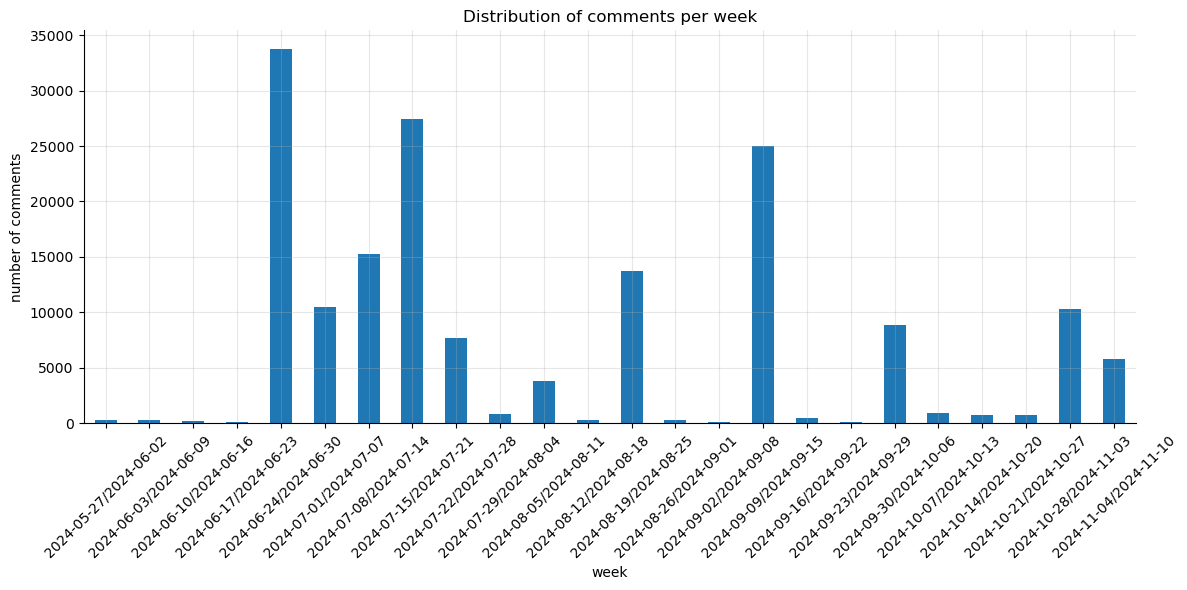

In [ ]:
# plot distribution of comments per week
plt.figure(figsize=(12, 6))
comments['date_day'].dt.to_period('W').value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of comments per week')
plt.xlabel('week')
plt.ylabel('number of comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
comments['week'] = comments['date_day'].dt.to_period('W')
sample_values = min(comments['week'].value_counts().sort_index())
sample_values

85

In [ ]:
# from each week, get random sample of 85 comments
comments_sample = comments.groupby('week').apply(lambda x: x.sample(sample_values)).reset_index(drop=True)
comments_sample = comments_sample.sort_values(by='datetime')
comments_sample

C:\Users\bnvul\AppData\Local\Temp\ipykernel_10152\4004539867.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comments_sample = comments.groupby('week').apply(lambda x: x.sample(85)).reset_index(drop=True)


,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day,week
31,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01,2024-05-27/2024-06-02
6,Conservative,t3_1d5divx,t1_l6ksnhq,t3_1d5divx,2024-06-01 05:55:10,18,18,A whole month? Didn't Pedo Joe just give them ...,2024-06-01,2024-05-27/2024-06-02
37,politics,t3_1d5ov0s,t1_l6mv0xy,t3_1d5ov0s,2024-06-01 17:14:25,21,21,R.J. Matson:\n \n[Trump felony convictionsouve...,2024-06-01,2024-05-27/2024-06-02
69,politics,t3_1d5ov0s,t1_l6mvnto,t3_1d5ov0s,2024-06-01 17:18:22,13,13,Fiona Katauskas:\n \n[The bestest!](,2024-06-01,2024-05-27/2024-06-02
27,politics,t3_1d5ov0s,t1_l6n421l,t1_l6mv2n4,2024-06-01 18:09:00,16,16,">Their Duty.\n\nJurors, as well as the judge a...",2024-06-01,2024-05-27/2024-06-02
...,...,...,...,...,...,...,...,...,...,...
2037,politics,t3_1gjdfxd,t1_lvfd5p2,t3_1gjdfxd,2024-11-04 23:36:50,11,11,Megyn MAGA SELLOUT Kelly is going to be at a T...,2024-11-04,2024-11-04/2024-11-10
2018,politics,t3_1gjdfxd,t1_lvffv4y,t1_lvfenrg,2024-11-04 23:51:39,2,2,Is Trump not also a war criminal,2024-11-04,2024-11-04/2024-11-10
1973,politics,t3_1gjdfxd,t1_lvfh2zg,t1_lvfgrqg,2024-11-04 23:58:16,1,1,"That's my thinking too. Biden, for all his suc...",2024-11-04,2024-11-04/2024-11-10
2027,politics,t3_1gjdfxd,t1_lvfoatr,t3_1gjdfxd,2024-11-05 00:38:01,25,25,"So legit question, something that I think the ...",2024-11-05,2024-11-04/2024-11-10


#### Biweekly

In [78]:
# read csv
comments = pd.read_csv('../data/processed/comments.csv')
# sort by date
comments = comments.sort_values(by='datetime')
# drop rows with missing values
comments = comments.dropna()
comments = comments.reset_index(drop=True)
comments['date_day'] = pd.to_datetime(comments['date_day'])

comments

,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
0,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
1,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
2,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
3,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
4,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01
...,...,...,...,...,...,...,...,...,...
167794,politics,t3_1gjdfxd,t1_lvfrzmk,t1_lvfrjhp,2024-11-05 00:58:37,7,7,"Trump up 4 points in Maryland!\n\n(""See? That ...",2024-11-05
167795,politics,t3_1gjdfxd,t1_lvfs1gu,t3_1gjdfxd,2024-11-05 00:58:54,12,12,"At this point the only states im ""worried"" abo...",2024-11-05
167796,politics,t3_1gjdfxd,t1_lvfs1k6,t1_lvfre42,2024-11-05 00:58:55,-5,-5,He's been saying the same script for the past ...,2024-11-05
167797,Conservative,t3_1gjrpbw,t1_lvfs3rk,t1_lvfqjvl,2024-11-05 00:59:17,49,49,This is the same county that the court case fo...,2024-11-05


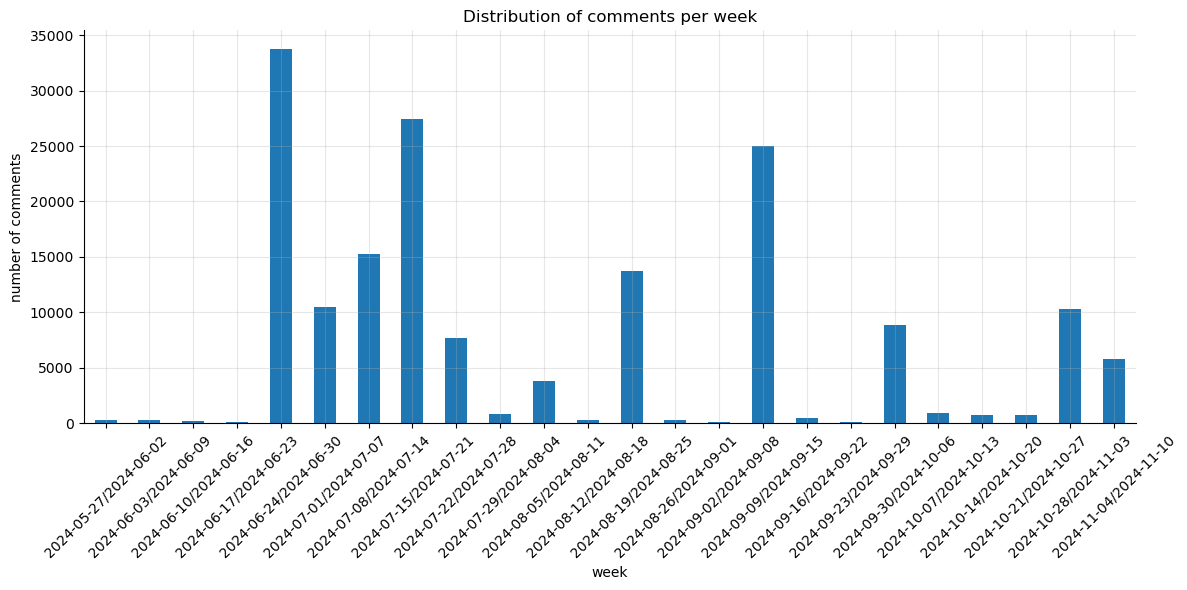

In [79]:
plt.figure(figsize=(12, 6))
comments['date_day'].dt.to_period('W').value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of comments per week')
plt.xlabel('week')
plt.ylabel('number of comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
#make the column date_day the index
biweekly_comments = comments.set_index('date_day', inplace=False)
sample_values = min(biweekly_comments.groupby(pd.Grouper(freq='2W'))['body'].count().sort_index())
sample_values

327

In [84]:
comments_sample = biweekly_comments.groupby(pd.Grouper(freq='2W')).apply(lambda x: x.sample(sample_values)).reset_index(drop=True)
comments_sample = comments_sample.sort_values(by='datetime')
comments_sample['datetime'] = pd.to_datetime(comments_sample['datetime'])
comments_sample

,subreddit,post_id,id,parent,datetime,score,upvotes,body
235,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who..."
135,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.
67,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...
1,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...
9,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...
...,...,...,...,...,...,...,...,...
3969,politics,t3_1gjdfxd,t1_lvfqq2x,t3_1gjdfxd,2024-11-05 00:51:27,14,14,"[\n\nTitle: 'In my humble view, lights out’: N..."
4243,politics,t3_1gjdfxd,t1_lvfqz6s,t3_1gjdfxd,2024-11-05 00:52:53,-8,-8,I'm in Australia and the bookmakers have Trump...
4230,politics,t3_1gjdfxd,t1_lvfr9ja,t3_1gjdfxd,2024-11-05 00:54:30,2,2,Anyone watching the Trump rally? I feel like h...
4109,politics,t3_1gjdfxd,t1_lvfr9p4,t3_1gjdfxd,2024-11-05 00:54:32,11,11,McCormick telling people to tell ten friends t...


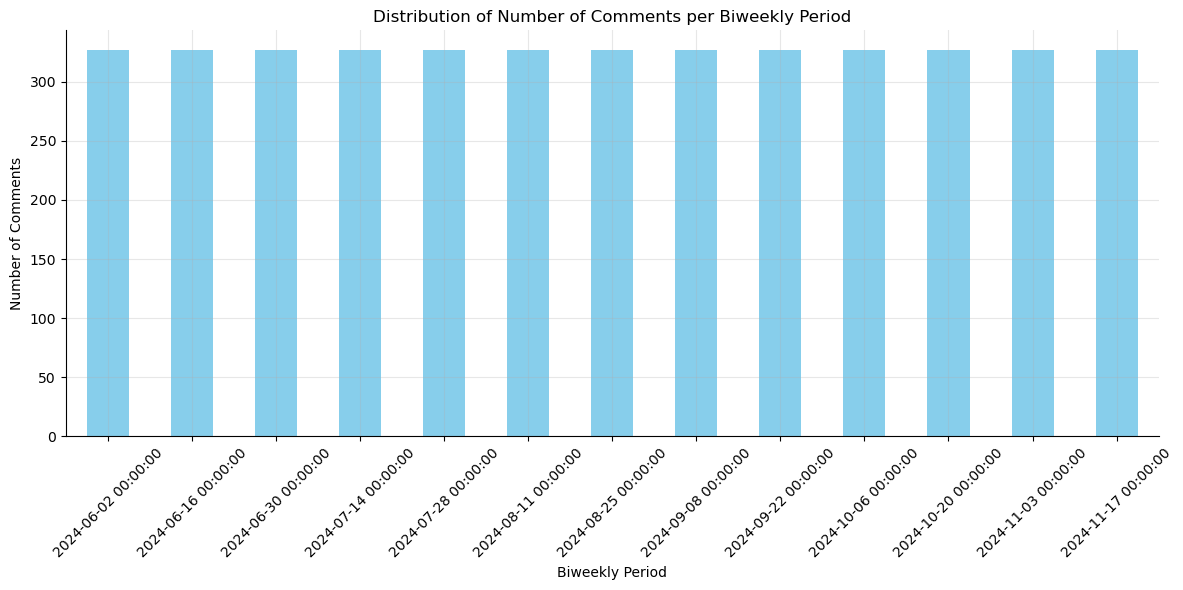

In [85]:
# Group by biweekly periods and count the number of comments in each period
biweekly_counts = comments_sample.set_index('datetime', inplace=False).groupby(pd.Grouper( freq='2W')).size()

# Plotting the distribution
plt.figure(figsize=(12, 6))
biweekly_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Number of Comments per Biweekly Period')
plt.xlabel('Biweekly Period')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [88]:
biweekly_counts

datetime
2024-06-02    327
2024-06-16    327
2024-06-30    327
2024-07-14    327
2024-07-28    327
2024-08-11    327
2024-08-25    327
2024-09-08    327
2024-09-22    327
2024-10-06    327
2024-10-20    327
2024-11-03    327
2024-11-17    327
Freq: 2W-SUN, dtype: int64

#### modeling

In [87]:
def preprocess_text(text):
    """
    Preprocess text for topic modeling.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # lowercase
    text = text.lower()

    # delete special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # tokenize
    tokens = word_tokenize(text)

    # delete stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
             if token not in stop_words and len(token) > 2]

    return tokens


# Aplicar preprocesamiento
comments_sample['processed_text'] = comments_sample['body'].swifter.apply(preprocess_text)

# Verificar el preprocesamiento
print("\nResults:")
print("Original:", comments_sample['body'].iloc[0])
print("Processed:", comments_sample['processed_text'].iloc[0])

Pandas Apply:   0%|          | 0/4251 [00:00<?, ?it/s]


Results:
Original: Bragg a commie? Nah, he's just a sycophant who will go along with whatever the Jackass party wants him to say. Biden says "Convict his political rival", Bragg says "For how long?".
Processed: ['bragg', 'commie', 'nah', 'he', 'sycophant', 'along', 'whatever', 'jackass', 'party', 'want', 'say', 'biden', 'say', 'convict', 'political', 'rival', 'bragg', 'say', 'long']


In [92]:
# create dictionary
dictionary = Dictionary(comments_sample['processed_text'])

# filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nVocabulary size:", len(dictionary))

# create corpus
corpus = [dictionary.doc2bow(doc) for doc in comments_sample['processed_text']]

# prepare time slices
# for weekly periods
# time_slices = comments_sample.groupby('week').size().tolist()

# for biweekly periods
time_slices = comments_sample.set_index('datetime', inplace=False).groupby(pd.Grouper( freq='2W')).size().tolist()


print("\nNumber of time periods:", len(time_slices))



Vocabulary size: 2623

Number of time periods: 13


In [93]:
# train LDA model
num_topics = 5  # number of topics
chain_variance = 0.100  # control how much the topics change over time

dtm = LdaSeqModel(
    corpus=corpus,
    time_slice=time_slices,
    num_topics=num_topics,
    id2word=dictionary,
    chain_variance=chain_variance,
    passes=10
)

c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * t

In [94]:
def print_topic_evolution(model, periods=None):
    """
    print the evolution of topics over time
    """
    num_time_slices = len(time_slices)
    for t in range(num_time_slices):
        print(f"\nPeríodo {t}:")
        for topic in range(model.num_topics):
            top_terms = model.print_topics(time=t)[topic]
            print(f"Tópico {topic}: {top_terms[:5]}")

# show topic evolution
print_topic_evolution(dtm)


Período 0:
Tópico 0: [('crime', 0.019671287650340156), ('law', 0.011125276497790536), ('case', 0.008481502304114175), ('judge', 0.008235705370756106), ('campaign', 0.008002974888013464)]
Tópico 1: [('biden', 0.04623028344185236), ('like', 0.02568467722772089), ('get', 0.014261255321468153), ('he', 0.013375636211138544), ('dont', 0.013073543123679735)]
Tópico 2: [('people', 0.02649016289532746), ('conservative', 0.015912697708640997), ('think', 0.012765897881018912), ('like', 0.011146157254790666), ('dont', 0.010369661887991575)]
Tópico 3: [('policy', 0.021004260166649087), ('democrat', 0.018127756224535503), ('biden', 0.014096871066884753), ('republican', 0.013250906014691649), ('state', 0.013092549166891617)]
Tópico 4: [('biden', 0.03141220129657963), ('president', 0.01646690003499422), ('year', 0.013410197161967239), ('country', 0.010151262671509726), ('office', 0.009727423183944473)]

Período 1:
Tópico 0: [('paxton', 0.01260959066412865), ('crime', 0.010029738792232597), ('would', 

In [ ]:
 
'''
1. Parameter Setting:
   - Modify num_topics and observe the changes.
   - Experiment with different chain_variance.
   - Try different temporal granularities
2. Temporal Analysis:
   - How do topics change?
   - Are there specific events that affect topics?
   - Which categories are most stable/variable?
3. Additional Visualizations:
   - Create a heatmap of temporal evolution.
   - Visualize the similarity between topics
   - Graph the evolution of specific categories
4. Preprocessing:
   - Adds/removes stopwords
   - Include bigraphs
   - Modify frequency filters
'''

'\n1. Parameter Setting:\n   - Modify num_topics and observe the changes.\n   - Experiment with different chain_variance.\n   - Try different temporal granularities\n2. Temporal Analysis:\n   - How do topics change month to month?\n   - Are there specific events that affect topics?\n   - Which categories are most stable/variable?\n3. Additional Visualizations:\n   - Create a heatmap of temporal evolution.\n   - Visualize the similarity between topics\n   - Graph the evolution of specific categories\n4. Preprocessing:\n   - Adds/removes stopwords\n   - Include bigraphs\n   - Modify frequency filters\n'

In [95]:
# save model
dtm.save('dtm_model_5topics_0_100chanin_biweekly')

# export topics evolution
topics_over_time = {}
num_time_slices = len(time_slices)

for t in range(num_time_slices):
    # obtain topics
    topics = dtm.print_topics(time=t)

    # save topics
    period_topics = {}
    for topic_id, topic_terms in enumerate(topics):
        period_topics[f'Topic_{topic_id}'] = topic_terms[:5] 

    topics_over_time[t] = period_topics

# dataframe
topics_df = pd.DataFrame.from_dict(topics_over_time, orient='index')

# save to csv
topics_df.to_csv('../data/mining/model_5topics_0_100chanin_biweekly.csv')


# Time series: Support score analysis

In [61]:
df_trump_biden = pd.read_csv('../data/processed/final_dataset_trump_biden.csv')
df_trump_harris = pd.read_csv('../data/processed/final_dataset_trump_harris.csv')

In [62]:
df_trump_harris.head()

,date_day,polls_Trump,polls_Harris,google_Harris,google_Trump,donald_trump_love,donald_trump_hate,kamala_harris_love,kamala_harris_hate
0,2024-07-24,0.440377,0.448710,0.105,0.075,0.352375,0.647625,0.486752,0.513248
1,2024-07-25,0.442427,0.446329,0.115,0.065,0.350676,0.649324,0.558862,0.441138
2,2024-07-26,0.440460,0.437328,0.085,0.060,0.367760,0.632240,0.428942,0.571058
3,2024-07-27,0.440216,0.437453,0.060,0.070,0.378309,0.621691,0.457191,0.542809
4,2024-07-28,0.441076,0.438446,0.050,0.070,0.293569,0.706431,0.378350,0.621650


In [63]:
df_love_trump_biden = df_trump_biden[['date_day','donald_trump_love', 'joe_biden_love']]
df_love_trump_harris = df_trump_harris[['date_day','donald_trump_love', 'kamala_harris_love']]

df_love_trump_biden.set_index('date_day', inplace=True)
df_love_trump_harris.set_index('date_day', inplace=True)

# convert to datetime
df_love_trump_biden.index = pd.to_datetime(df_love_trump_biden.index)
df_love_trump_harris.index = pd.to_datetime(df_love_trump_harris.index)

df_love_trump_biden.asfreq('D')
df_love_trump_harris.asfreq('D')


,donald_trump_love,kamala_harris_love
date_day,,
2024-07-24,0.352375,0.486752
2024-07-25,0.350676,0.558862
2024-07-26,0.367760,0.428942
2024-07-27,0.378309,0.457191
2024-07-28,0.293569,0.378350
...,...,...
2024-11-01,0.353853,0.551061
2024-11-02,0.344661,0.571459
2024-11-03,0.347723,0.582334


## Trump, Biden

In [64]:
trump_love = df_love_trump_biden['donald_trump_love']
biden_love = df_love_trump_biden['joe_biden_love']

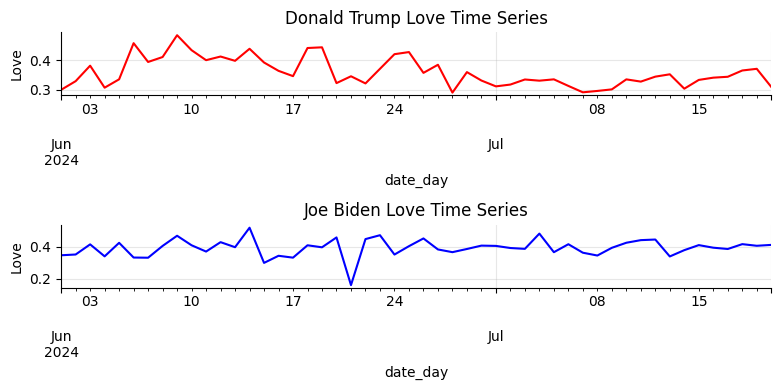

In [65]:
# make 2 subplots for trump and biden love time series
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
trump_love.plot(ax=ax[0], color='red')
ax[0].set_title('Donald Trump Love Time Series')
ax[0].set_ylabel('Love')
biden_love.plot(ax=ax[1], color='blue')
ax[1].set_title('Joe Biden Love Time Series')
ax[1].set_ylabel('Love')
plt.tight_layout()
plt.show()


### Dickie-Fuller test

In [66]:
# Perform Dickie-Fuller test for stationarity on both time series
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickie-Fuller test:
    print('Results of Dickie-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
print('Trump Love Time Series:')
test_stationarity(trump_love)
print()
print('Biden Love Time Series:')
test_stationarity(biden_love)

Trump Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                 -3.776781
p-value                         0.003154
#Lags Used                      0.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64

Biden Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                -6.594023e+00
p-value                        6.998457e-09
#Lags Used                     1.000000e+00
Number of Observations Used    4.800000e+01
Critical Value (1%)           -3.574589e+00
Critical Value (5%)           -2.923954e+00
Critical Value (10%)          -2.600039e+00
dtype: float64


**Trump Love Time Series**

Test Statistic: -3.776781
p-value: 0.003154
Critical Values:
1%: -3.571472
5%: -2.922629
10%: -2.599336

Interpretation:
- The test statistic (-3.776781) is lower than all the critical values (1%, 5%, and 10%).
- The p-value (0.003154) is significantly less than 0.05, which means we reject the null hypothesis.

**Conclusion: The series is stationary.**

**Biden Love Time Series**

Test Statistic: -6.594023
p-value: 6.998457e-09 (~0.000000007)
Critical Values:
1%: -3.574589
5%: -2.923954
10%: -2.600039

Interpretation:
The test statistic (-6.594023) is much lower than all the critical values.
The p-value (~0.000000007) is extremely small, allowing us to confidently reject the null hypothesis.

**Conclusion: The series is stationary.**

Train-test split: 90-10

In [67]:

train_size = int(len(trump_love) * 0.9)  
trump_love_train = trump_love.iloc[:train_size]   
trump_love_test = trump_love.iloc[train_size:]     
biden_love_train = biden_love.iloc[:train_size]   
biden_love_test = biden_love.iloc[train_size:]    

### ACF

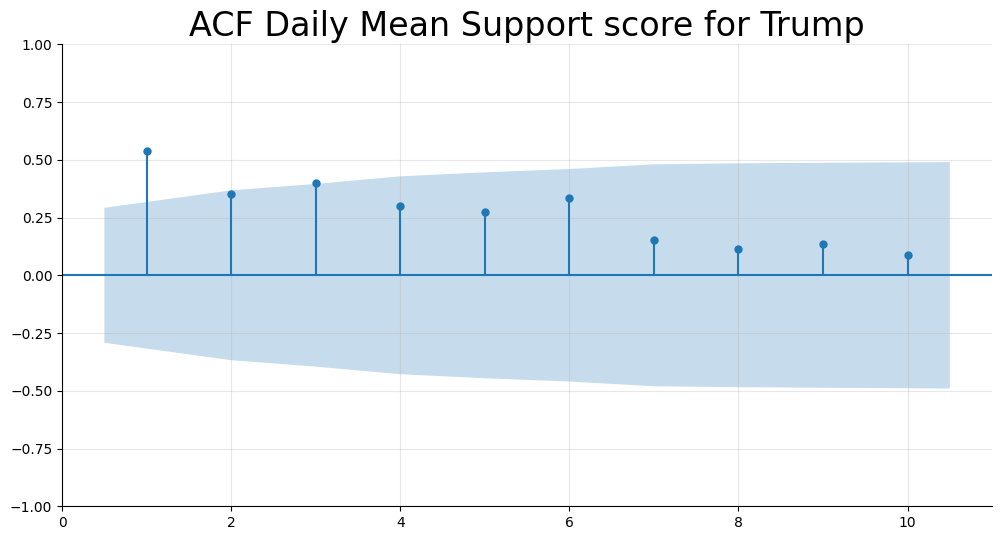

In [68]:
sgt.plot_acf(trump_love_train, lags = 10, zero = False)
plt.title("ACF Daily Mean Support score for Trump", size = 24)
plt.show()

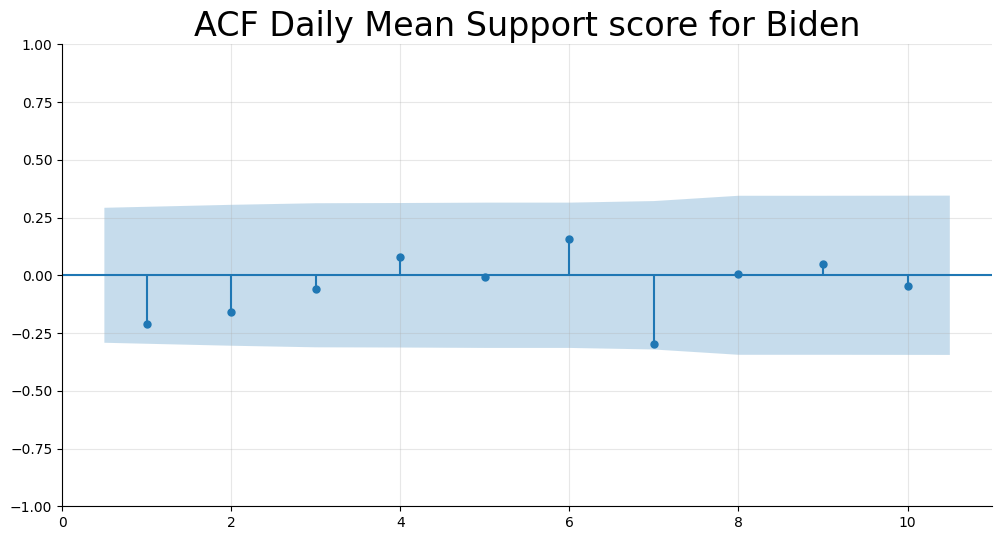

In [69]:
sgt.plot_acf(biden_love_train, lags = 10, zero = False)
plt.title("ACF Daily Mean Support score for Biden", size = 24)
plt.show()

### PACF

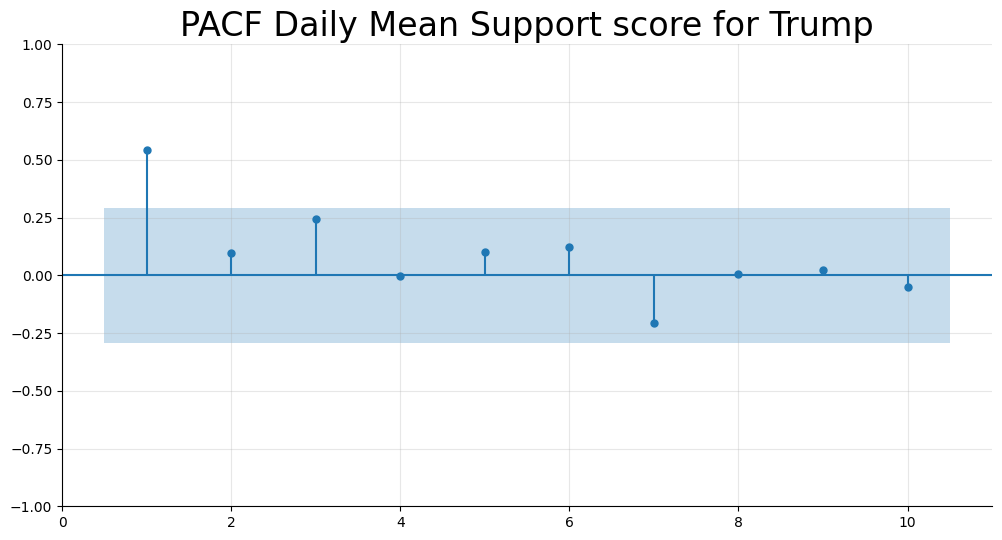

In [70]:
sgt.plot_pacf(trump_love_train, lags = 10, zero = False, method = ('ols'))
plt.title("PACF Daily Mean Support score for Trump", size = 24)
plt.show()

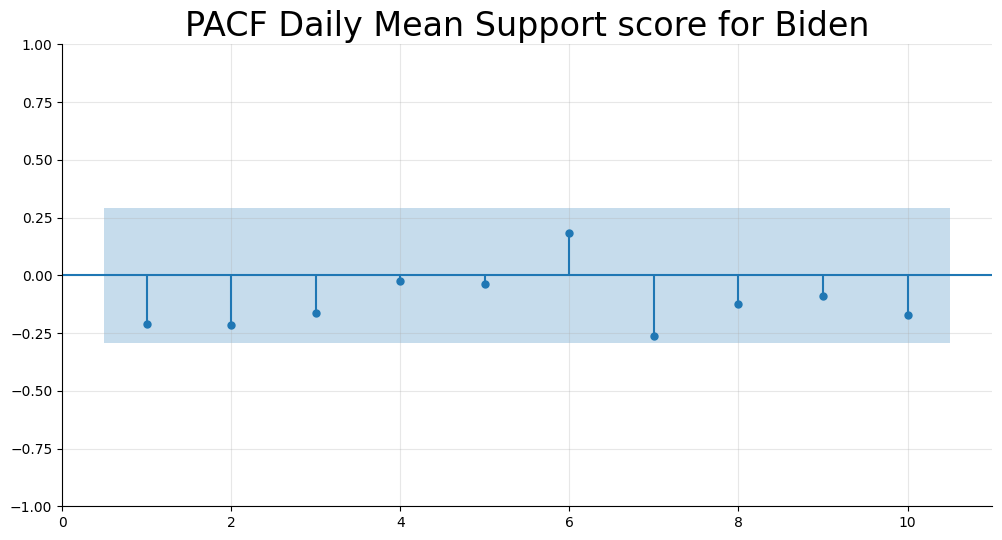

In [71]:
sgt.plot_pacf(biden_love_train, lags = 10, zero = False, method = ('ols'))
plt.title("PACF Daily Mean Support score for Biden", size = 24)
plt.show()

### ARMA

Trump arma

In [72]:
trump_arima = pm.auto_arima(trump_love_train, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            max_p=10,
                            max_q=10)
trump_arima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-148.103, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-137.237, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-151.173, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-147.902, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.012, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-149.608, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-150.660, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-149.157, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.163 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  78.587
Date:                Tue, 19 Nov 2024   AIC                           -151.173
Time:                        10:06:06   BIC                           -145.753
Sample:                    06-01-2024   HQIC                          -149.153
                         - 07-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1613      0.061      2.660      0.008       0.042       0.280
ar.L1          0.5510      0.160      3.439      0.001       0.237       0.865
sigma2         0.0018      0.000      4.682      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.68   Prob(JB):                         0.37
Heteroskedasticity (H):               0.24   Skew:                             0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Biden arma

In [73]:
biden_arima = pm.auto_arima(biden_love_train, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            max_p=10,
                            max_q=10)

biden_arima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-122.426, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-124.419, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-124.473, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-126.029, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=46.484, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-121.180, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-125.697, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-123.802, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7.191, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.183 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  66.015
Date:                Tue, 19 Nov 2024   AIC                           -126.029
Time:                        10:06:07   BIC                           -120.609
Sample:                    06-01-2024   HQIC                          -124.009
                         - 07-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3928      0.006     68.603      0.000       0.382       0.404
ma.L1         -0.3687      0.181     -2.036      0.042      -0.724      -0.014
sigma2         0.0031      0.000      6.419      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                18.60
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.70
Prob(H) (two-sided):                  0.23   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Forecasting

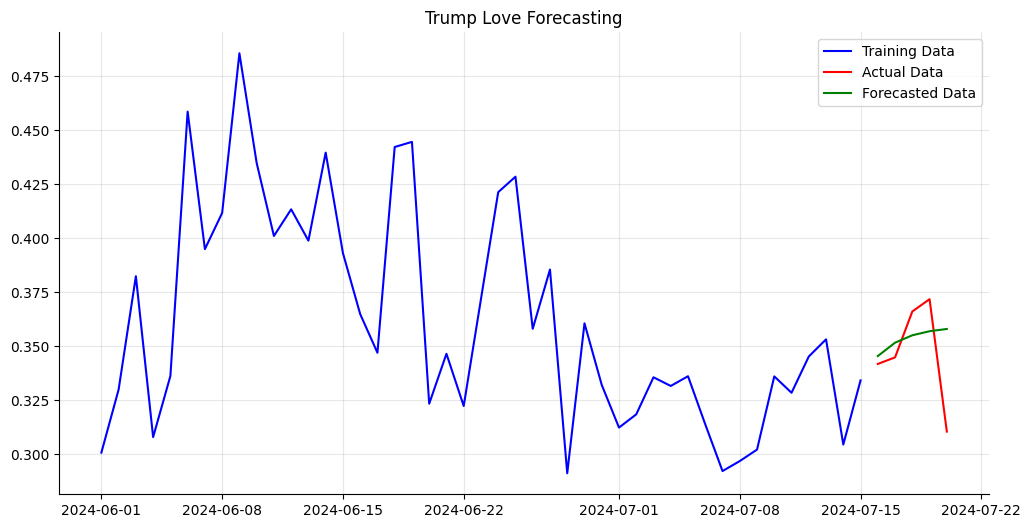

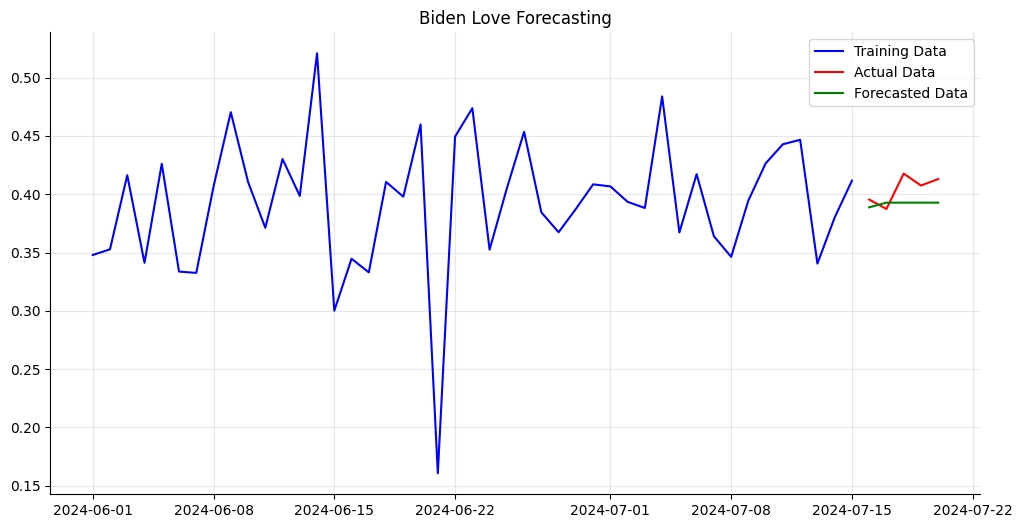

In [74]:
results_arma_trump_forecast = trump_arima.predict(n_periods=len(trump_love_test))
results_arma_biden_forecast = biden_arima.predict(n_periods=len(biden_love_test))

# Plot the forecasted values vs the actual test values
plt.figure(figsize=(12, 6))
plt.plot(trump_love_train, label='Training Data', color='blue')
plt.plot(trump_love_test, label='Actual Data', color='red')
plt.plot(results_arma_trump_forecast, label='Forecasted Data', color='green')
plt.title('Trump Love Forecasting')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(biden_love_train, label='Training Data', color='blue')
plt.plot(biden_love_test, label='Actual Data', color='red')
plt.plot(results_arma_biden_forecast, label='Forecasted Data', color='green')
plt.title('Biden Love Forecasting')
plt.legend()
plt.show()




## Trump, Harris

In [75]:
trump_love = df_love_trump_harris['donald_trump_love']
harris_love = df_love_trump_harris['kamala_harris_love']


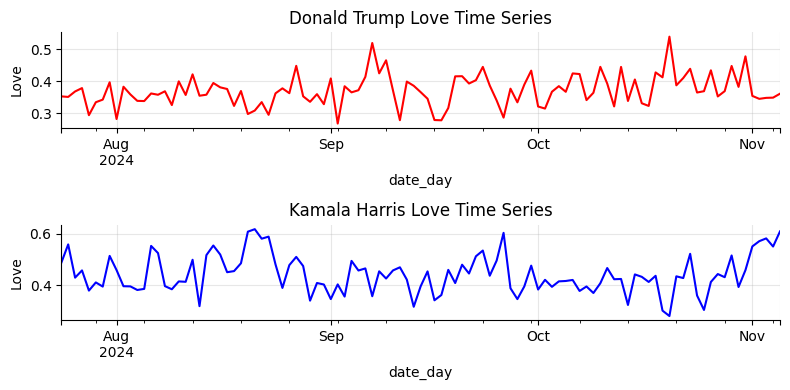

In [76]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
trump_love.plot(ax=ax[0], color='red')
ax[0].set_title('Donald Trump Love Time Series')
ax[0].set_ylabel('Love')
harris_love.plot(ax=ax[1], color='blue')
ax[1].set_title('Kamala Harris Love Time Series')
ax[1].set_ylabel('Love')
plt.tight_layout()


### Dickie-Fuller test

In [77]:
# Perform Dickie-Fuller test for stationarity on both time series
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickie-Fuller test:
    print('Results of Dickie-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
print('Trump Love Time Series:')
test_stationarity(trump_love)
print()
print('Harris Love Time Series:')
test_stationarity(harris_love)

Trump Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                -8.337694e+00
p-value                        3.238774e-13
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64

Harris Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                -6.062660e+00
p-value                        1.202221e-07
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


**Trump Love Time Series:**

The test statistic is significantly lower than the critical values at all levels (1%, 5%, 10%), and the p-value is very small (far below 0.05). This suggests rejecting the null hypothesis of a unit root (non-stationarity), **this suggests that the Trump Love time series is stationary.**

**Harris Love Time Series:**

Similarly, the test statistic is significantly lower than the critical values, and the p-value is also very small, leading to the rejection of the null hypothesis, **indicating that the Harris Love time series is also stationary.**

Train-test split: 90-10

In [78]:
train_size = int(len(trump_love) * 0.9)  
trump_love_train = trump_love.iloc[:train_size]   
trump_love_test = trump_love.iloc[train_size:]     
harris_love_train = harris_love.iloc[:train_size]
harris_love_test = harris_love.iloc[train_size:]

### ACF

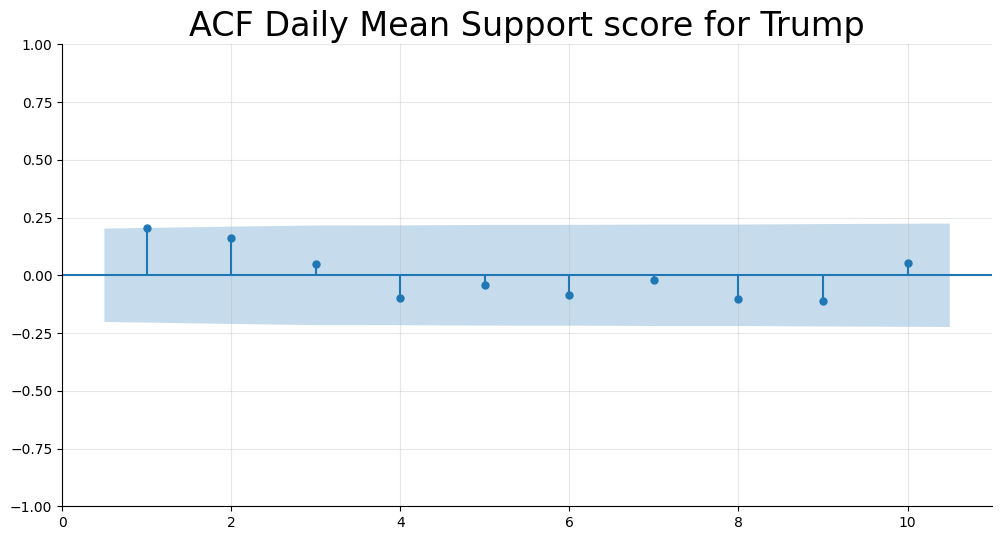

In [79]:
sgt.plot_acf(trump_love_train, lags = 10, zero = False)
plt.title("ACF Daily Mean Support score for Trump", size = 24)
plt.show()

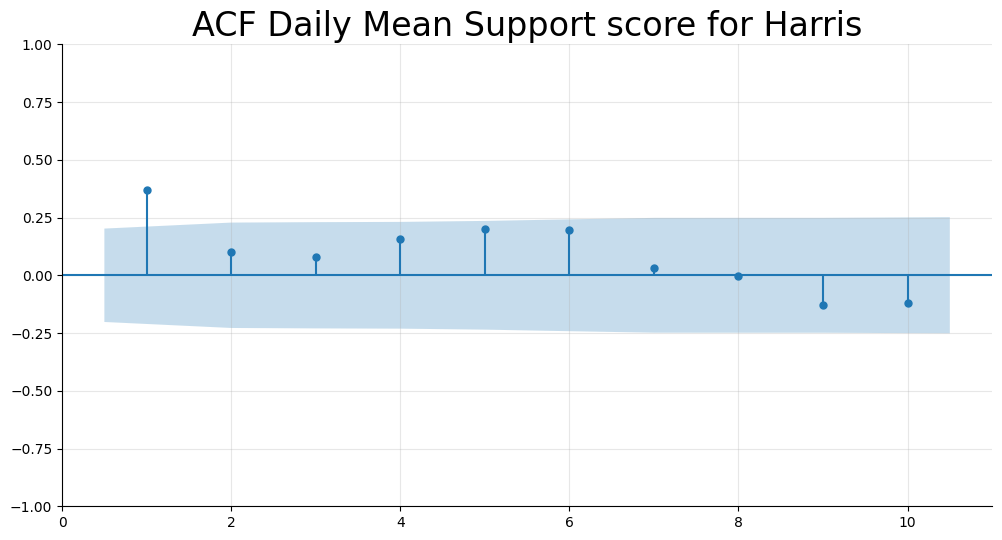

In [80]:
sgt.plot_acf(harris_love_train, lags = 10, zero = False)
plt.title("ACF Daily Mean Support score for Harris", size = 24)
plt.show()

### PACF

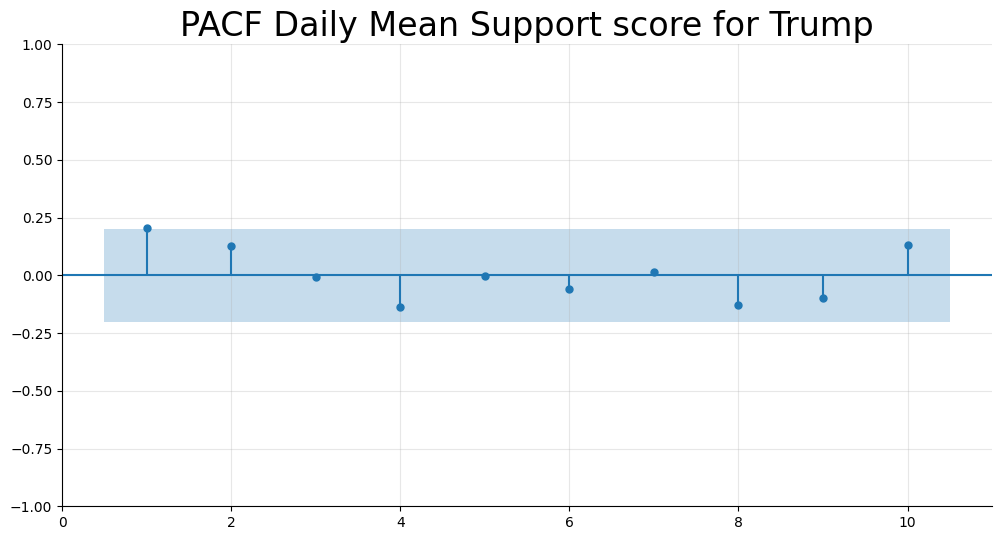

In [81]:
sgt.plot_pacf(trump_love_train, lags = 10, zero = False, method = ('ols'))
plt.title("PACF Daily Mean Support score for Trump", size = 24)
plt.show()

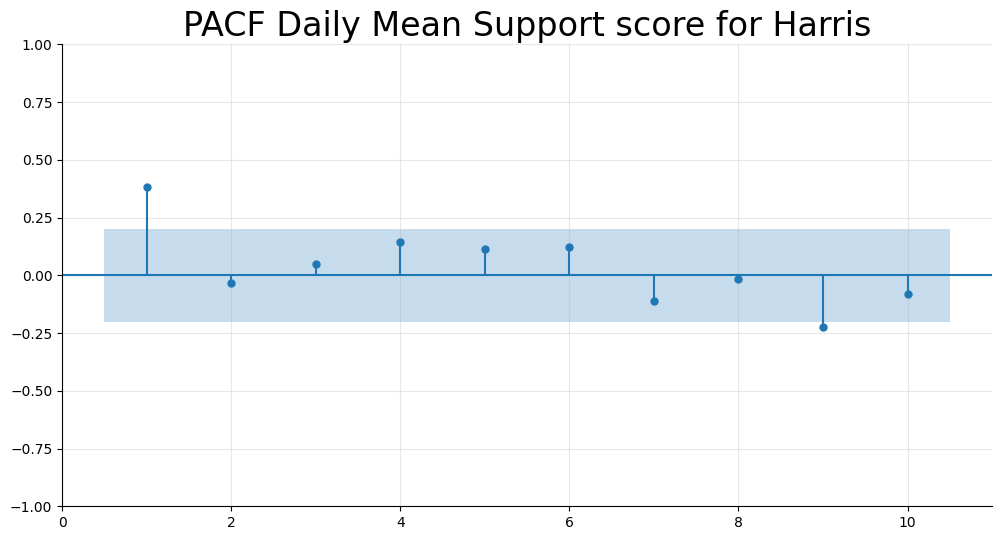

In [82]:
sgt.plot_pacf(harris_love_train, lags = 10, zero = False, method = ('ols'))
plt.title("PACF Daily Mean Support score for Harris", size = 24)
plt.show()

### ARMA

Trump arma

In [83]:
trump_arima = pm.auto_arima(trump_love_train, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            max_p=10,
                            max_q=10)
trump_arima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-292.165, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-294.110, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-296.153, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-295.283, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=83.172, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-295.614, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-295.053, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-293.615, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-246.879, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.174 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   94
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 151.076
Date:                Tue, 19 Nov 2024   AIC                           -296.153
Time:                        10:06:41   BIC                           -288.523
Sample:                    07-24-2024   HQIC                          -293.071
                         - 10-25-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2932      0.046      6.373      0.000       0.203       0.383
ar.L1          0.2061      0.122      1.682      0.093      -0.034       0.446
sigma2         0.0024      0.000      7.377      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.93
Prob(Q):                              0.80   Prob(JB):                         0.09
Heteroskedasticity (H):               2.02   Skew:                             0.43
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Harris arma

In [84]:
harris_arima = pm.auto_arima(harris_love_train, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            max_p=10,
                            max_q=10)
harris_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-233.094, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-225.757, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-238.075, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-237.088, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=114.908, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-236.177, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-236.199, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-234.116, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-203.630, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.172 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   94
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 122.038
Date:                Tue, 19 Nov 2024   AIC                           -238.075
Time:                        10:06:42   BIC                           -230.445
Sample:                    07-24-2024   HQIC                          -234.993
                         - 10-25-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2685      0.040      6.734      0.000       0.190       0.347
ar.L1          0.3824      0.087      4.400      0.000       0.212       0.553
sigma2         0.0044      0.001      6.131      0.000       0.003       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.89   Prob(JB):                         0.69
Heteroskedasticity (H):               0.81   Skew:                             0.09
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Forecasting

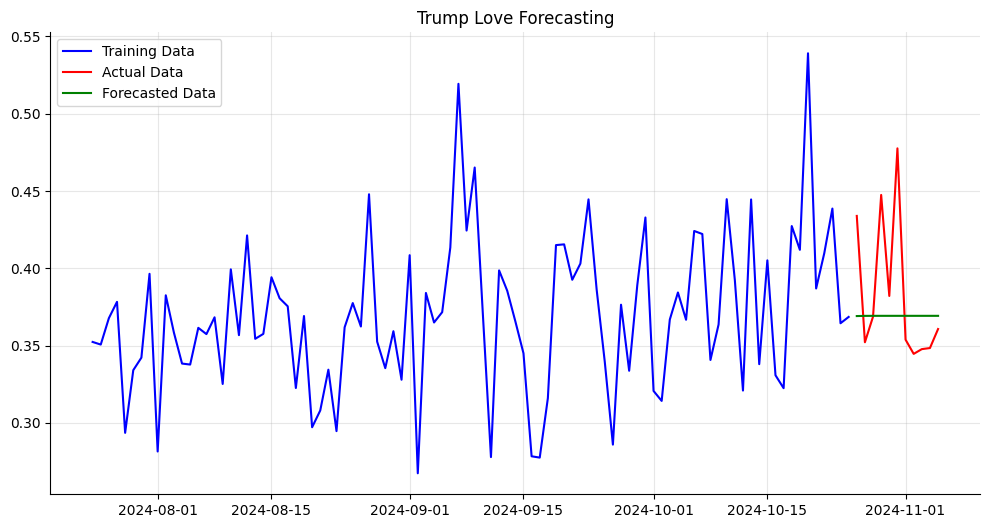

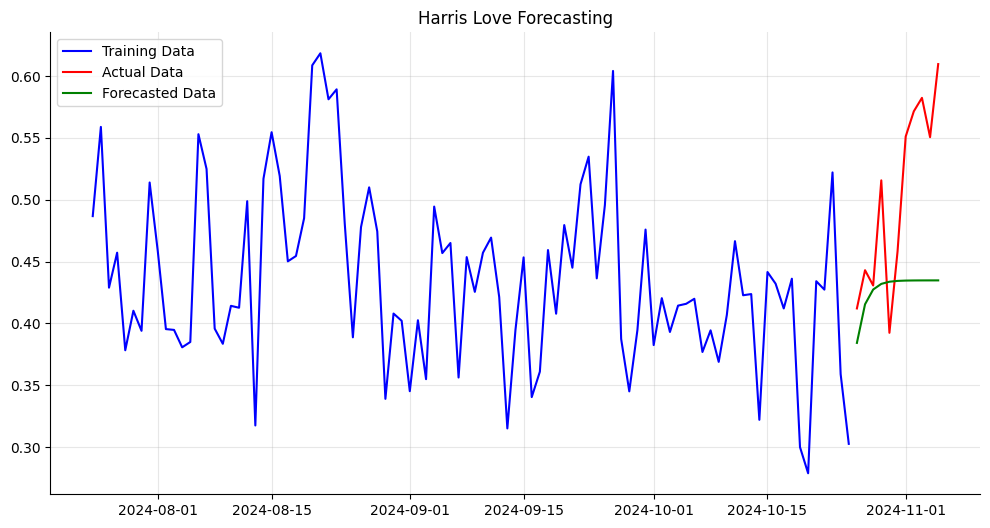

In [85]:
results_arma_trump_forecast = trump_arima.predict(n_periods=len(trump_love_test))
results_arma_harris_forecast = harris_arima.predict(n_periods=len(harris_love_test))

# Plot the forecasted values vs the actual test values
plt.figure(figsize=(12, 6))
plt.plot(trump_love_train, label='Training Data', color='blue')
plt.plot(trump_love_test, label='Actual Data', color='red')
plt.plot(results_arma_trump_forecast, label='Forecasted Data', color='green')
plt.title('Trump Love Forecasting')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(harris_love_train, label='Training Data', color='blue')
plt.plot(harris_love_test, label='Actual Data', color='red')
plt.plot(results_arma_harris_forecast, label='Forecasted Data', color='green')
plt.title('Harris Love Forecasting')
plt.legend()
plt.show()


## Support difference Trump-Biden, Trump-Harris

In [86]:
trump_biden_diff = df_love_trump_biden['donald_trump_love'] - df_love_trump_biden['joe_biden_love']
trump_harris_diff = df_love_trump_harris['donald_trump_love'] - df_love_trump_harris['kamala_harris_love']
trump_harris_diff.index = pd.to_datetime(trump_harris_diff.index)
trump_biden_diff.index = pd.to_datetime(trump_biden_diff.index)


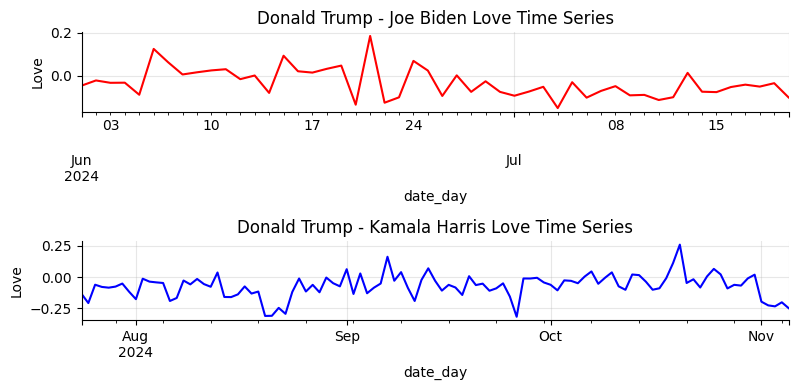

In both cases, higher than 0 means that Trump is more loved than the other candidate.


In [87]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
trump_biden_diff.plot(ax=ax[0], color='red')
ax[0].set_title('Donald Trump - Joe Biden Love Time Series')
ax[0].set_ylabel('Love')
trump_harris_diff.plot(ax=ax[1], color='blue')
ax[1].set_title('Donald Trump - Kamala Harris Love Time Series')
ax[1].set_ylabel('Love')
plt.tight_layout()
plt.show()

print('In both cases, higher than 0 means that Trump is more loved than the other candidate.')

### Dickie-Fuller test

In [88]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickie-Fuller test:
    print('Results of Dickie-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
print('Trump - Biden Love Time Series:')
test_stationarity(trump_biden_diff)
print()
print('Trump - Harris Love Time Series:')
test_stationarity(trump_harris_diff)

Trump - Biden Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                 -1.451469
p-value                         0.557368
#Lags Used                      6.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64

Trump - Harris Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                -6.155197e+00
p-value                        7.397471e-08
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


**Trump - Biden Love Time Series:**

Test Statistic: -1.451469
p-value: 0.557368
Since the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that this time series is **non-stationary** (i.e., it has a unit root).
Critical Values: The test statistic is higher than all the critical values (at 1%, 5%, and 10%), confirming the failure to reject the null hypothesis of a unit root.

**Trump - Harris Love Time Series:**

Test Statistic: -6.155197
p-value: 7.397471e-08
Since the p-value is much smaller than 0.05, we reject the null hypothesis and conclude that this time series is **stationary** (i.e., it does not have a unit root).
Critical Values: The test statistic is significantly lower than the critical values at all levels, confirming the rejection of the null hypothesis.

In [106]:
train_size_biden = int(len(trump_biden_diff) * 0.8)
train_size_harris = int(len(trump_harris_diff) * 0.8)
trump_biden_diff_train = trump_biden_diff.iloc[:train_size_biden]
trump_biden_diff_test = trump_biden_diff.iloc[train_size_biden:]
trump_harris_diff_train = trump_harris_diff.iloc[:train_size_harris]
trump_harris_diff_test = trump_harris_diff.iloc[train_size_harris:]



### ACF

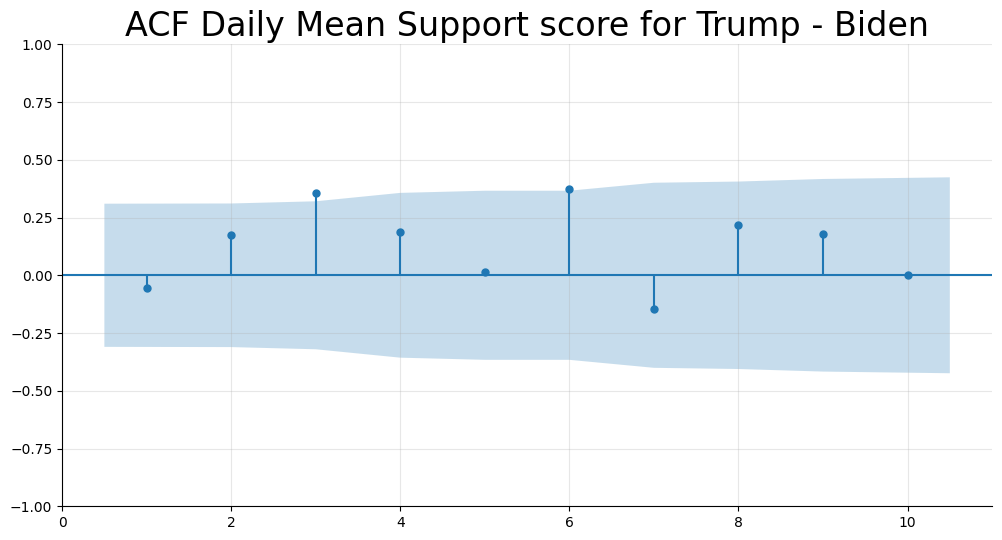

In [107]:
sgt.plot_acf(trump_biden_diff_train, lags = 10, zero = False)
plt.title("ACF Daily Mean Support score for Trump - Biden", size = 24)
plt.show()


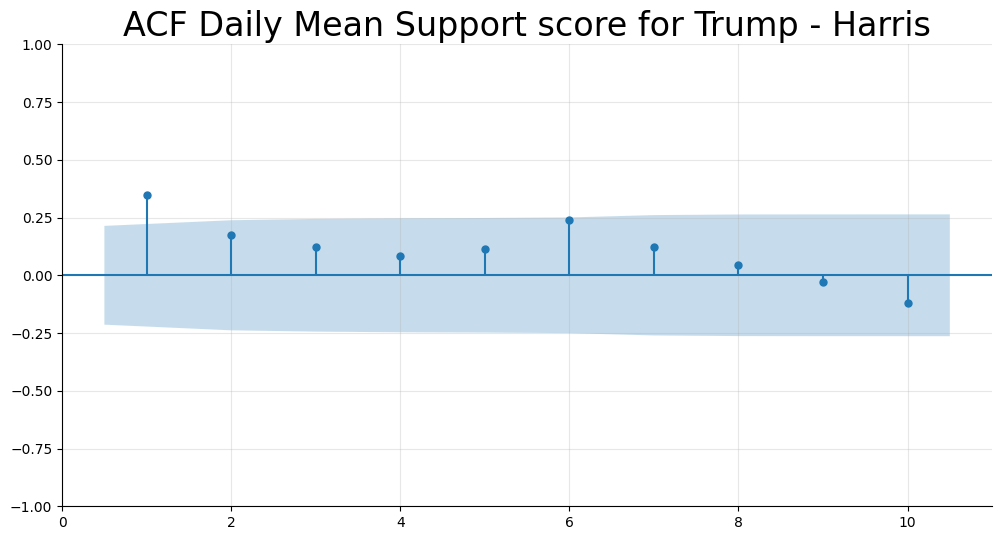

In [108]:
sgt.plot_acf(trump_harris_diff_train, lags = 10, zero = False)
plt.title("ACF Daily Mean Support score for Trump - Harris", size = 24)
plt.show()

### PACF

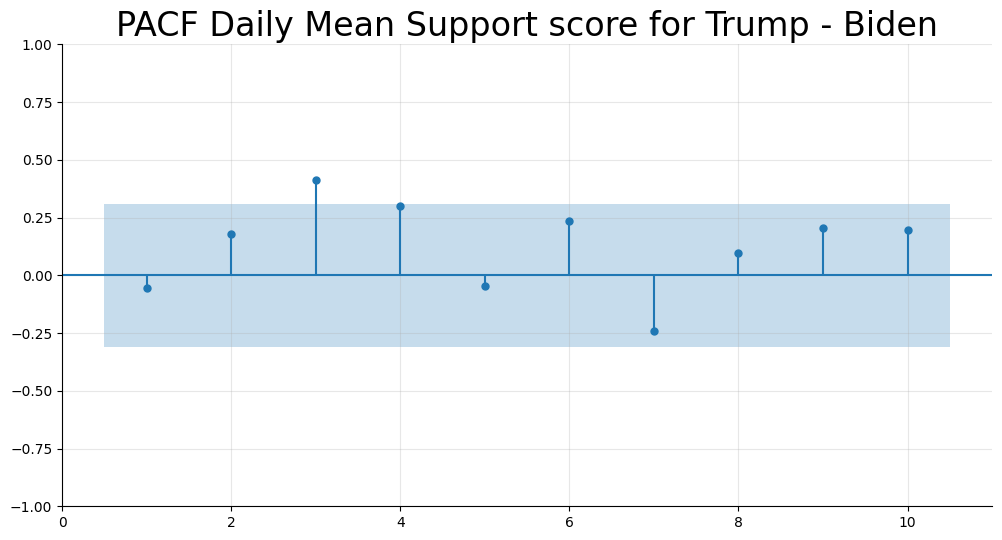

In [109]:
sgt.plot_pacf(trump_biden_diff_train, lags = 10, zero = False, method = ('ols'))
plt.title("PACF Daily Mean Support score for Trump - Biden", size = 24)
plt.show()

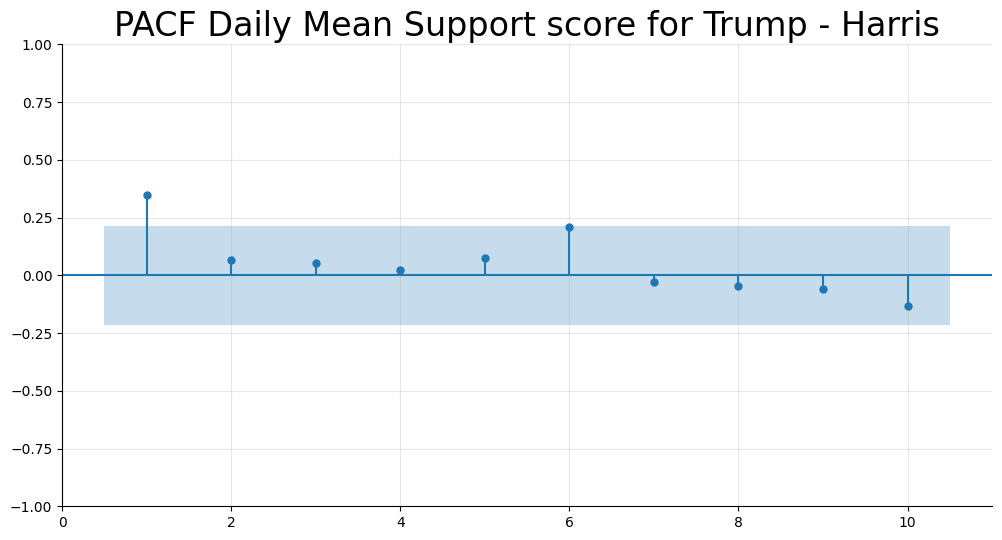

In [110]:
sgt.plot_pacf(trump_harris_diff_train, lags = 10, zero = False, method = ('ols'))
plt.title("PACF Daily Mean Support score for Trump - Harris", size = 24)
plt.show()


### AR(I)MA

Trump-Biden arima

In [111]:
trump_biden_arima = pm.auto_arima(trump_biden_diff_train, seasonal = False, stationary=False, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            max_p=10,
                            max_q=10,
                            max_d=5)
trump_biden_arima.summary()
                                  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-90.060, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.328, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.479, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.323, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-90.818, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-92.758, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-90.924, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-91.288, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-88.859, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-94.351, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-90.204, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-92.386, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-92.436, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-92.634, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  50.175
Date:                Tue, 19 Nov 2024   AIC                            -94.351
Time:                        10:12:20   BIC                            -89.360
Sample:                    06-01-2024   HQIC                           -92.560
                         - 07-10-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1706      0.133     -8.771      0.000      -1.432      -0.909
ma.L2          0.3954      0.134      2.958      0.003       0.133       0.657
sigma2         0.0043      0.001      4.726      0.000       0.003       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.78   Prob(JB):                         0.87
Heteroskedasticity (H):               0.34   Skew:                             0.08
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Trump-Harris arima

In [112]:
trump_harris_arima = pm.auto_arima(trump_harris_diff_train, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            max_p=10,
                            max_q=10,
                            max_d=5)

trump_harris_arima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-173.412, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-170.066, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-178.867, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-177.055, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-124.402, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-177.226, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-177.392, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-175.955, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-164.247, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.166 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  92.433
Date:                Tue, 19 Nov 2024   AIC                           -178.867
Time:                        10:12:21   BIC                           -171.574
Sample:                    07-24-2024   HQIC                          -175.935
                         - 10-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0491      0.013     -3.644      0.000      -0.076      -0.023
ar.L1          0.3465      0.093      3.710      0.000       0.163       0.530
sigma2         0.0065      0.001      6.993      0.000       0.005       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.36
Prob(Q):                              0.86   Prob(JB):                         0.51
Heteroskedasticity (H):               0.95   Skew:                            -0.19
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

forecasting

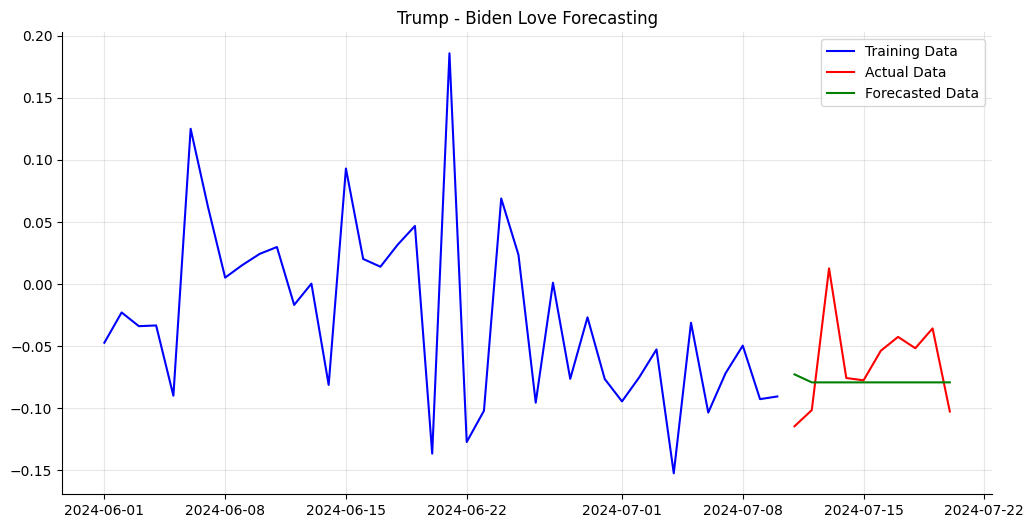

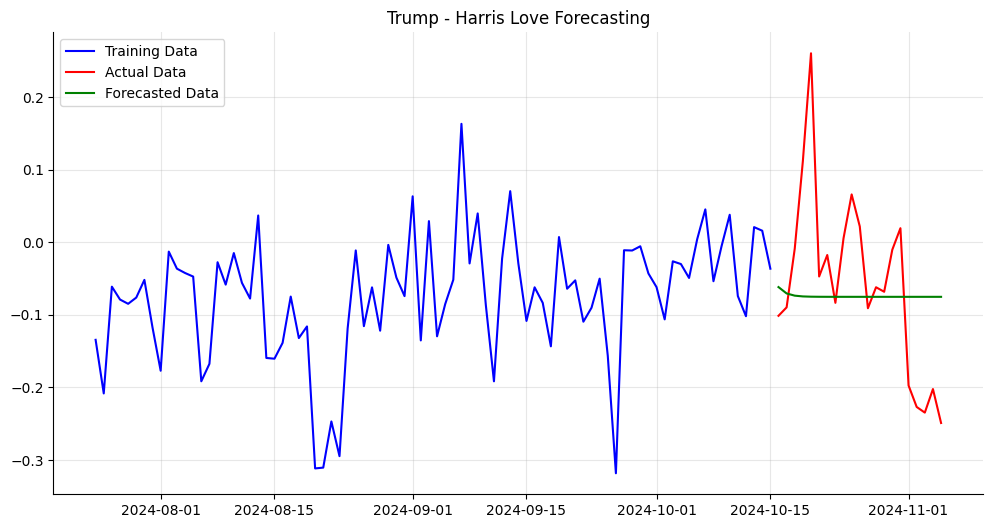

In [113]:

results_arma_trump_biden_forecast = trump_biden_arima.predict(n_periods=len(trump_biden_diff_test))
results_arma_trump_harris_forecast = trump_harris_arima.predict(n_periods=len(trump_harris_diff_test))

# Plot the forecasted values vs the actual test values
plt.figure(figsize=(12, 6))
plt.plot(trump_biden_diff_train, label='Training Data', color='blue')
plt.plot(trump_biden_diff_test, label='Actual Data', color='red')
plt.plot(results_arma_trump_biden_forecast, label='Forecasted Data', color='green')
plt.title('Trump - Biden Love Forecasting')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(trump_harris_diff_train, label='Training Data', color='blue')
plt.plot(trump_harris_diff_test, label='Actual Data', color='red')
plt.plot(results_arma_trump_harris_forecast, label='Forecasted Data', color='green')
plt.title('Trump - Harris Love Forecasting')
plt.legend()

plt.show()
